# Harmful Comment Detection in Social Media Posts

Mental health issues among teens and young adults have been on the rise and widespread use of social media is believed one of the major factors behind the issue. With the help of Machine Learning (ML) it is feasible to shield teens from harmful comments and posts present in various social media platforms. 

This study will focus on how Machine Learning can be used to detect harmful comments and posts utilizing Natural Language Processing. The goal is to identify comment and posts with harmful content so such items can be filtered an only non-harmful items are visible to teens in the social media posts.

In [30]:
# import modules
import string
import re
import pandas as pd
from time import time
import numpy as np
# import unicodedata
# import sys

# import modules for text preprocessing
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
# from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

# import modules for text vectorization 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# for plotting confusion matrix
import matplotlib as mpl 
import matplotlib.cm as cm 
import matplotlib.pyplot as plt 
import itertools


# import classifiers from sklearn
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split

# import different metrics to evaluate the classifiers
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, roc_auc_score
from sklearn.metrics import confusion_matrix 
from sklearn import metrics
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold, learning_curve, LearningCurveDisplay, ValidationCurveDisplay

#### Load and explore dataset

In [2]:
df = pd.read_csv("./datasets/train.csv")

In [3]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


#### Analysis

In [4]:
# check for missing values
df.isna().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

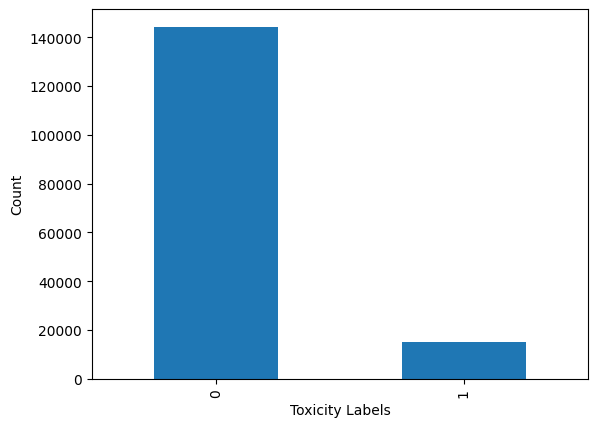

In [5]:
# distribution of toxic labels
df["toxic"].value_counts().plot(kind="bar")
plt.xlabel("Toxicity Labels")
plt.ylabel("Count")
plt.show()

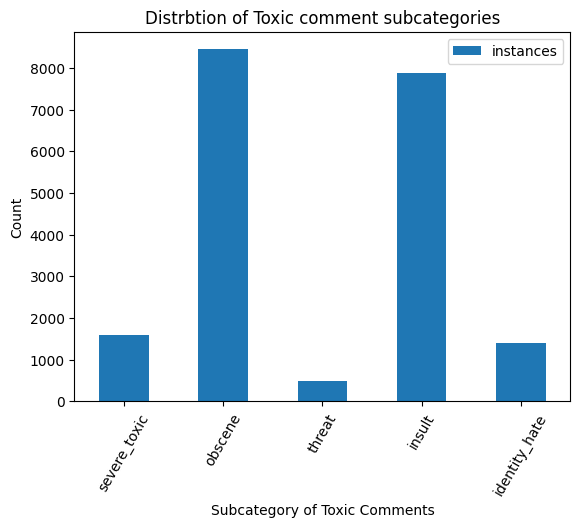

In [6]:
# Distribution of toxicity sub categories
counts = []
for sub_category in ["severe_toxic","obscene","threat","insult","identity_hate"]:
    counts.append(int(df[sub_category].sum()))
sub_cat = pd.DataFrame(np.array(counts),index=["severe_toxic","obscene","threat","insult","identity_hate"], columns=["instances"])
sub_cat.plot(kind="bar")
plt.title("Distrbtion of Toxic comment subcategories")
plt.ylabel("Count")
plt.xlabel("Subcategory of Toxic Comments")
plt.xticks(rotation=60)
plt.show()

In [7]:
# this function removes stopwords from input text
    
def custom_standardization_fn(text):
    lowercase_string = text.lower()
    regex_punc = re.sub(
        f"[0-9{re.escape(string.punctuation)}]", lambda match: "" , lowercase_string)
    regex_clean = re.sub(
        f"[\\r\\t\\n]", lambda match: " " , regex_punc)

    stop_words = stopwords.words("english")
    tokenized_words = word_tokenize(regex_clean)
    stop_word_removed_tokens = [word for word in tokenized_words if word not in stop_words]
    stopword_removed_string = " ".join([word for word in tokenized_words if word not in stop_words])
    # lemmatize
    wnl = WordNetLemmatizer()
    return " ".join([wnl.lemmatize(words) for words in stop_word_removed_tokens])

# def custom_split_fn(string_tensor):
#     return tf.strings.split(string_tensor) 

In [8]:
df["cleaned_text"] = df["comment_text"].apply(custom_standardization_fn)

In [9]:
# veiw few comments after preprocessing
df[["cleaned_text","toxic"]].head()

,cleaned_text,toxic
0,explanation edits made username hardcore metal...,0
1,daww match background colour im seemingly stuc...,0
2,hey man im really trying edit war guy constant...,0
3,cant make real suggestion improvement wondered...,0
4,sir hero chance remember page thats,0


In [10]:
# perform train test split
X = df["cleaned_text"]
y = df["toxic"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [11]:
# view train test dimensions
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(119678,) (119678,)
(39893,) (39893,)


#### Text vectorization

In [12]:
# Preprocess and Vectorize train and test data
vect = CountVectorizer() # instantiate a vectoriezer
X_train_dtm = vect.fit_transform(X_train)# use it to extract features from training data
# transform testing data (using training data's features)
X_test_dtm = vect.transform(X_test)
print(X_train_dtm.shape, X_test_dtm.shape)

(119678, 176910) (39893, 176910)


#### Training and Validation

In [13]:
# Function to plot confusion matrix. 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize=15)
    plt.xlabel('Predicted label',fontsize=15)
    
    


1. Naive Bayes with all features from text vectorization

Accuracy:  0.9488130749755597
ROC_AOC_Score:  0.8977714549756235


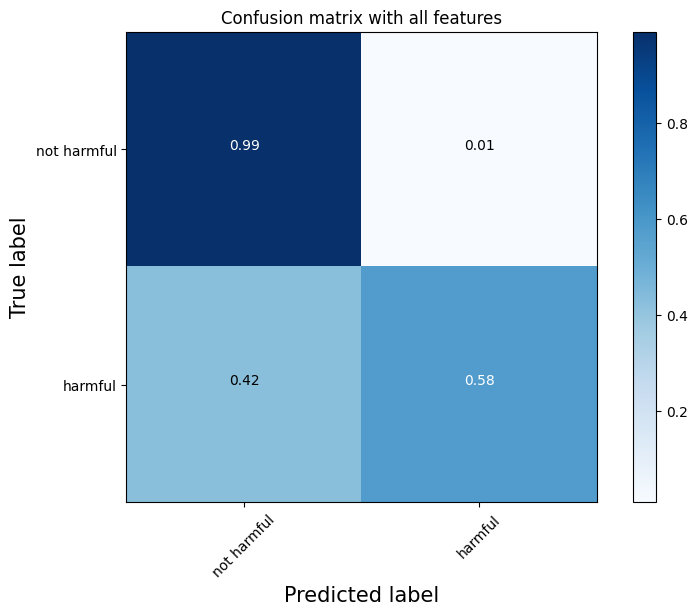

In [14]:
# Train the classifier and predict for test data
nb = MultinomialNB() # instantiate a Multinomial Naive Bayes model
nb.fit(X_train_dtm, y_train) 
y_pred_class = nb.predict(X_test_dtm)
# Print accuracy:
print("Accuracy: ", accuracy_score(y_test, y_pred_class))

    
# print the confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=['not harmful','harmful'],normalize=True,
                      title='Confusion matrix with all features')

# calculate AUC: Area under the curve(AUC) 

y_pred_prob = nb.predict_proba(X_test_dtm)[:, 1]
print("ROC_AOC_Score: ", roc_auc_score(y_test, y_pred_prob))

2. Naive Bayes with 10000 features

In [15]:
vect = CountVectorizer(max_features=10000) # Step-1
X_train_dtm = vect.fit_transform(X_train) 
X_test_dtm = vect.transform(X_test)
nb = MultinomialNB() # instantiate a Multinomial Naive Bayes model
nb.fit(X_train_dtm, y_train)
y_pred_class = nb.predict(X_test_dtm)
print("Accuracy: ", metrics.accuracy_score(y_test, y_pred_class))
# calculate AUC: Area under the curve(AUC) 
y_pred_prob = nb.predict_proba(X_test_dtm)[:, 1]
print("ROC_AOC_Score: ", roc_auc_score(y_test, y_pred_prob))

Accuracy:  0.9491640137367457
ROC_AOC_Score:  0.9309808230623977


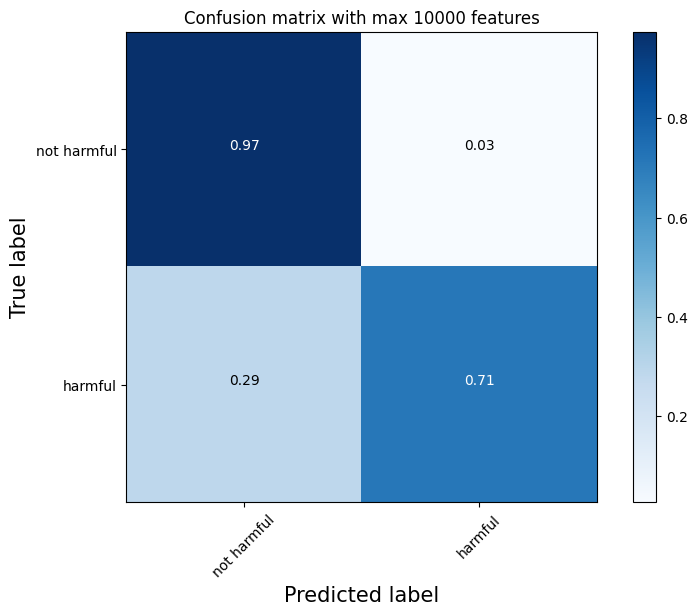

In [16]:
# print the confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=['not harmful','harmful'],normalize=True,
                      title='Confusion matrix with max 10000 features')

3. Logistic Regression with 10000 features

In [17]:
logreg = LogisticRegression(class_weight="balanced", max_iter=1500) # instantiate a logistic regression model
logreg.fit(X_train_dtm, y_train) # fit the model with training data

# Make predictions on test data
y_pred_class = logreg.predict(X_test_dtm)

# calculate evaluation measures:
print("Accuracy: ", accuracy_score(y_test, y_pred_class))
print("AUC: ", roc_auc_score(y_test, y_pred_prob))


Accuracy:  0.936555285388414
AUC:  0.9309808230623977


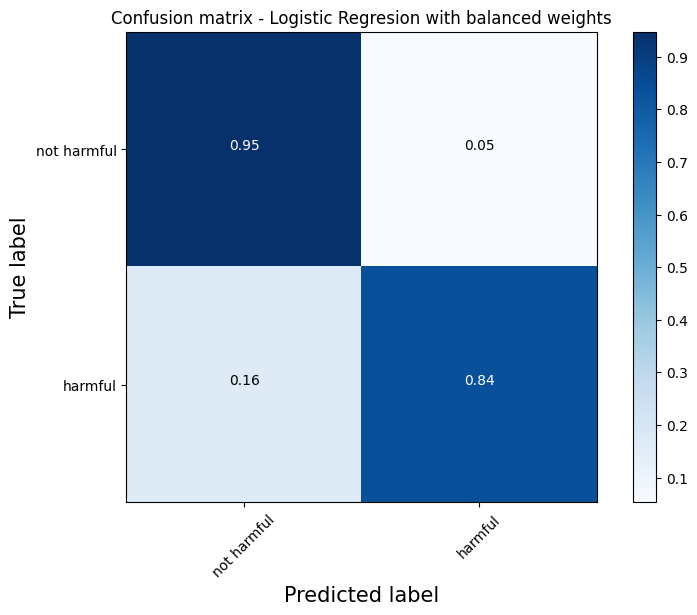

In [18]:
# plot confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=['not harmful','harmful'],normalize=True,
                      title='Confusion matrix - Logistic Regresion with balanced weights')

In [19]:
# print classification report
print(classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

           0       0.98      0.95      0.96     35996
           1       0.63      0.84      0.72      3897

    accuracy                           0.94     39893
   macro avg       0.81      0.89      0.84     39893
weighted avg       0.95      0.94      0.94     39893



4. SVM with 10000 features

In [20]:
vect = CountVectorizer(max_features=10000) # Step-1
X_train_dtm = vect.fit_transform(X_train) # combined step 2 and 3
X_test_dtm = vect.transform(X_test)

classifier = LinearSVC(class_weight='balanced', C=0.001) # instantiate a SVC model
classifier.fit(X_train_dtm, y_train) # fit the model with training data

# Make predictions on test data
y_pred_class = classifier.predict(X_test_dtm)

# calculate evaluation measures:
print("Accuracy: ", accuracy_score(y_test, y_pred_class))
print("AUC: ", roc_auc_score(y_test, y_pred_prob))

Accuracy:  0.9323690873085504
AUC:  0.9309808230623977


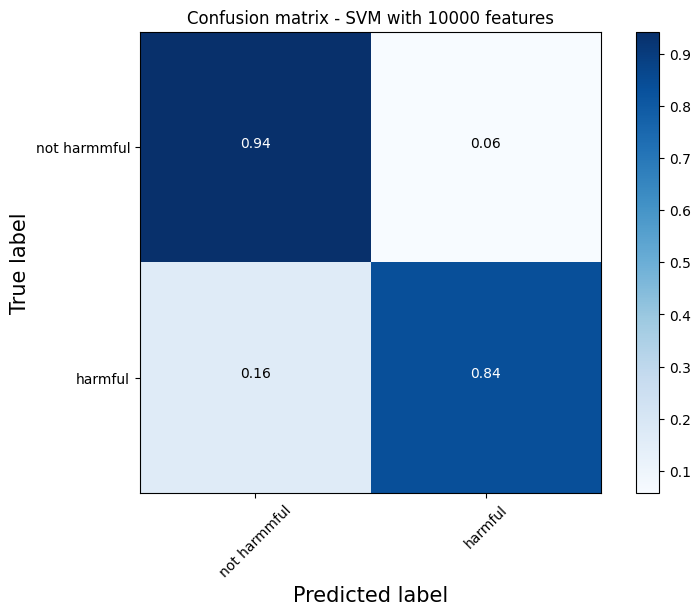

In [21]:
# display confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=['not harmmful','harmful'],normalize=True,
                      title='Confusion matrix - SVM with 10000 features')

In [22]:
# print classification report
print(classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

           0       0.98      0.94      0.96     35996
           1       0.61      0.84      0.71      3897

    accuracy                           0.93     39893
   macro avg       0.80      0.89      0.83     39893
weighted avg       0.95      0.93      0.94     39893



Perform 10-fold cross validation with the Logistic Regression Model to test model fit

In [23]:
#define Stratified Kfold cross validation object
stratified_cv = StratifiedKFold(
    n_splits=10,
    shuffle=True,
    random_state=1
)

In [24]:
# perform cross validation
scores_lr = cross_val_score(logreg, 
                                  X_train_dtm, 
                                  y_train,
                                  cv=stratified_cv,
                                  scoring="recall",
                                  verbose=1
                                 )

In [25]:
# print the average scores from the 10-fold cross validation
for i, score in enumerate(scores_lr):
    print(f"Fold#{i}, Score:{score}")

Fold#0, Score:0.8129938542581212
Fold#1, Score:0.8105263157894737
Fold#2, Score:0.8517543859649123
Fold#3, Score:0.8219298245614035
Fold#4, Score:0.8298245614035088
Fold#5, Score:0.8324561403508772
Fold#6, Score:0.8377192982456141
Fold#7, Score:0.8298245614035088
Fold#8, Score:0.8191395961369623
Fold#9, Score:0.8244073748902546


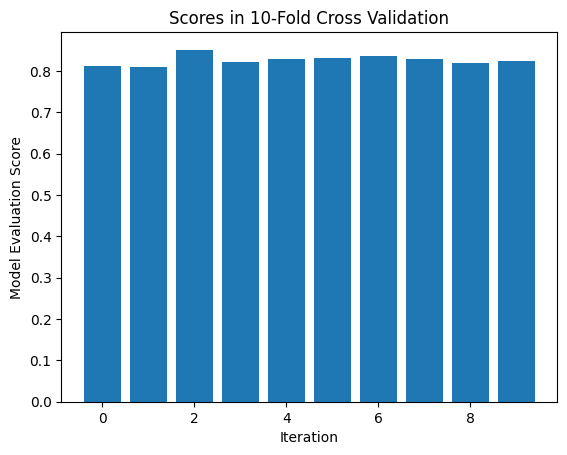

In [27]:
plt.bar(x=np.array(range(0,10)), height=scores_lr)
plt.title("Scores in 10-Fold Cross Validation")
plt.xlabel("Iteration")
plt.ylabel("Model Evaluation Score")
plt.show()

Check if more instances will help using Learning Curve

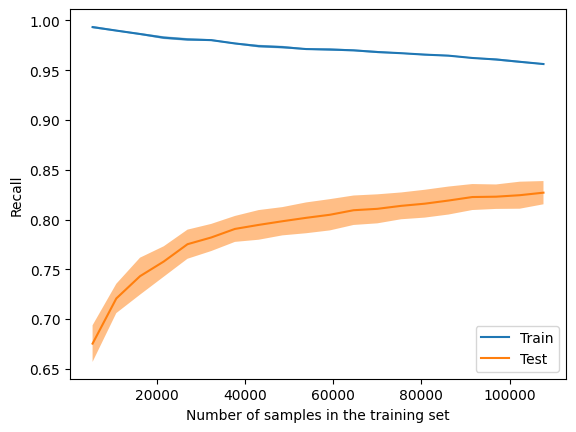

In [29]:
LearningCurveDisplay.from_estimator(
    logreg,
    X_train_dtm, 
    y_train,
    train_sizes=np.linspace(0.05,1,num=20),
    cv=stratified_cv,
    scoring="recall"
)
plt.show()

Seems like there is scope to improve the model score to some extent by increasing the number of samples